In [1]:
!pip install --upgrade ultralytics==8.0.186
!pip install torch torchvision torchaudio
!pip install opencv-python-headless
!pip install albumentations==1.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.4/618.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from ultralytics import YOLO
import numpy as np
from google.colab import drive
import os
import albumentations
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_yolo = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Senior-Design-VIAD'
epoch_number = 50
weights_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/YoloV8/yolov8n.pt'
data_yaml_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Senior-Design-VIAD/data.yaml'
saved_path = f'trained_model'
results_folder_name = f"{dataset_yolo}_normal"

# model = YOLO(weights_path)
# model.train(
#     data=data_yaml_path,
#     epochs=epoch_number,
#     batch=40,
#     device='cuda',
#     project=saved_path,
#     name=results_folder_name,
#     patience=epoch_number,
#     pretrained=True,
#     lr0=0.01,
#     lrf=0.001,
#     dropout=0.2
# )

In [ ]:
data_yaml_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Senior-Design-VIAD/data.yaml'
with open(data_yaml_path, 'r') as f:
    print(f.read())  # 检查文件内容

test: /content/drive/My Drive/2024 Fall/COMS 6730/Projects/Senior-Design-VIAD/test/images
train: /content/drive/My Drive/2024 Fall/COMS 6730/Projects/Senior-Design-VIAD/train/images
val: /content/drive/My Drive/2024 Fall/COMS 6730/Projects/Senior-Design-VIAD/valid/images

nc: 26
names: ['bench', 'bicycle', 'branch', 'bus', 'bushes', 'car', 'crosswalk', 'door', 'elevator', 'fire_hydrant', 'green_light', 'gun', 'motorcycle', 'person', 'pothole', 'rat', 'red_light', 'scooter', 'stairs', 'stop_sign', 'traffic_cone', 'train', 'tree', 'truck', 'umbrella', 'yellow_light']

roboflow:
  workspace: viad-optics-senior-design
  project: senior-design-viad
  version: 5
  license: CC BY 4.0
#   url: https://universe.roboflow.com/viad-optics-senior-design/senior-design-viad/dataset/5


In [ ]:
# transform = transforms.Compose([
#     transforms.Resize((img_size, img_size)),
#     transforms.ToTensor(),
# ])

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, alpha=0.8, beta=0.5, gamma=0.7):
        super(CustomLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.epsilon = 1e-6

    def forward(self, outputs, targets):
        # 获取模型输出所在的设备
        device = outputs[0].boxes.conf.device

        # 提取 boxes 属性并移动到相同设备
        boxes = outputs[0].boxes

        # 将 conf 和 cls 张量移至正确设备
        person_conf = boxes.conf.to(device)  # 置信度分数
        person_cls = (boxes.cls == targets['person_class_index']).float().to(device)  # 类别是人物的概率

        # 将 targets 张量移至正确设备
        person_mask = targets['person_mask'].float().to(device)  # 人物区域的掩码
        background_mask = (1.0 - person_mask).to(device)         # 背景区域的掩码

        # 背景区域的误检损失
        L_bg = -torch.sum(
            (torch.log(person_cls + self.epsilon) + torch.log(person_conf + self.epsilon)) * background_mask
        ) / (torch.sum(background_mask) + self.epsilon).to(device)

        # 现有人物区域的抑制损失
        L_person = torch.sum(
            (torch.log(1.0 - person_cls + self.epsilon) + torch.log(1.0 - person_conf + self.epsilon)) * person_mask
        ) / (torch.sum(person_mask) + self.epsilon).to(device)

        # 边界框数量增加损失
        L_bbox = -torch.mean(torch.log(person_conf + self.epsilon)).to(device)

        # 总损失
        loss = self.alpha * L_bg + self.beta * L_person + self.gamma * L_bbox

        return loss

In [36]:
model_path = f"{results_folder_name}/weights/last.pt"
model = YOLO(model_path)
# model.eval()

/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:527: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file  # load


In [5]:
with torch.no_grad():
    # 禁用参数的更新
    for param in model.parameters():
        param.requires_grad = False


In [6]:
def pgd_attack(model, images, epsilon, alpha, num_iter, target_class=13):
    """
    执行标准 PGD 攻击，最大化对抗扰动使模型对目标类别的置信度增加。
    参数:
        model: 加载的目标检测模型
        images: 输入图像 (tensor)，形状为 [B, C, H, W]
        epsilon: 扰动范围
        alpha: 每步的扰动步长
        num_iter: 迭代次数
        labels: 图像的真实标签，用于计算损失
        target_class: 目标类别索引 (int)，如果为 None，则对现有检测框增加误检
    返回:
        images_adv: 生成的对抗样本
    """
    # 克隆输入图像，确保不修改原始图像，并设置需要计算梯度
    images_adv = images.clone().detach().requires_grad_(True)

    # 启用梯度计算
    with torch.enable_grad():
        for i in range(num_iter):
            # 获取模型输出
            images_adv.retain_grad()
            outputs = model(images_adv)

            # 从输出中提取置信度分数 (例如 outputs[0].boxes.conf)
            confidences = outputs[0].boxes.conf  # 获取检测框的置信度分数
            # print(confidences)
            if target_class is not None:
                # 如果指定了 target_class，我们对该类别的概率进行攻击
                classes = outputs[0].boxes.cls
                target_conf = confidences[classes == target_class]
                if len(target_conf) == 0:  # 如果没有检测到目标类别，跳过本次迭代
                    continue
                Closs = -torch.mean(target_conf)  # 目标是增加对抗样本对目标类别的置信度
            else:
                # 如果未指定 target_class，则增加所有检测框的误检概率
                Closs = torch.mean(confidences)  # 目标是增加所有框的置信度

            # loss = -images_adv.mean()
            loss = images_adv.mean() - Closs
            # 打印损失值（可选）
            print(loss)

            # 反向传播以计算梯度
            loss.requires_grad_(True)
            loss.backward(retain_graph=True)

            if images_adv.grad is None:
                print("images_adv.grad is None after backward")
                break

            # 获取梯度的符号
            grad_sign = images_adv.grad.sign()

            # 更新对抗样本
            images_adv = images_adv + alpha * grad_sign

            # 限制扰动范围并确保像素值在 [0, 1] 之间
            eta = torch.clamp(images_adv - images, min=-epsilon, max=epsilon)
            images_adv = torch.clamp(images + eta, min=0, max=3).detach()

            # 重新启用梯度以继续迭代
            images_adv.requires_grad_(True)

    return images_adv

In [44]:
class_range = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]

In [74]:
import random

def draw_boxes(image, outputs, class_names=None, color=(0, 255, 0)):
    """
    在图像上绘制检测框。

    参数：
        image: 原始图像（numpy 数组）
        outputs: YOLO 模型的输出
        class_names: 类别名称列表，例如 ['Person', 'Car', ...]
        color: 框的颜色（BGR 格式）
    返回：
        带有检测框的图像
    """
    # 复制图像，避免直接修改原图
    image_with_boxes = image.copy()

    # 获取检测框信息
    boxes = outputs[0].boxes  # 这是 YOLO 输出的检测框对象

    if boxes is None:
        print("No objects detected.")
        return image_with_boxes

    # 遍历所有检测框
    for box in boxes:
        # 提取框的坐标和置信度
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())  # 转换为整数
        conf = float(box.conf[0])  # 置信度分数
        cls = int(box.cls[0])  # 类别索引

        if int(cls)==13:
          color=(0, 255, 0)
        else:
          color = (int(cls)*10, int(cls)*10, int(cls)*10)

        if class_names and cls < len(class_names):
            label = f"{class_names[cls]}: {conf:.2f}"
        else:
            label = f"Class {cls}: {conf:.2f}"  # 如果超出范围，直接使用类别索引

        # 绘制矩形框
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), color, 2)
        print(f"{conf:.2f}")
        # 显示类别和置信度
        label = f"{class_names[cls] if class_names else cls}: {conf:.2f}"
        cv2.putText(image_with_boxes, label, (x1 + 10, y1 + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return image_with_boxes

In [31]:
def preprocess_image(image, size=(640, 640)):
    """
    预处理图像，将图像调整为模型输入尺寸，并归一化到 [0, 1]。
    参数:
        image: 原始图像 (numpy 数组)
        size: 调整后的尺寸 (宽, 高)
    返回:
        PyTorch 张量，形状为 [1, 3, H, W]
    """
    # 调整图像大小
    image_resized = cv2.resize(image, size)

    # 转换为 [C, H, W] 格式，并归一化到 [0, 1]
    image_tensor = torch.tensor(image_resized, dtype=torch.float32).permute(2, 0, 1) / 255.0

    # 增加 batch 维度 [B, C, H, W]
    return image_tensor.unsqueeze(0)

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 生成检测框图像
# image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Senior-Design-VIAD/train/images/2bfc68c9de334fdfac0c7514e98068f5246d4f8e_jpg.rf.577a69123c2218c40378ffd7781d3c68.jpg'
# image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/50_png.rf.8c631fbfe884e8a35e7a9592242389f1.jpg'
# image = cv2.imread(image_path)
# image_tensor = preprocess_image(image, size=(640, 640))

# # image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
# # image_tensor = image_tensor.to(device)  # 将 Tensor 移动到 GPU（如果可用）

# # 传入模型
# # outputs = model(image_tensor)

# outputs = model.predict(image_tensor)

# # 将图像和标签转换为 Tensor
# images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
# labels = torch.tensor([0]).to(device)

# # 生成对抗样本
# print("Generating adversarial examples...")
# images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# # 使用对抗样本进行预测
# outputs_adv = model(images_adv)

In [76]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/50_png.rf.8c631fbfe884e8a35e7a9592242389f1.jpg'
image = cv2.imread(image_path)

image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
image_tensor = image_tensor.to(device)  # 将 Tensor 移动到 GPU（如果可用）

# 传入模型
# outputs = model(image_tensor)

outputs = model.predict(image_tensor)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 person, 1 scooter, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 scooter, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.2ms postprocess per image at 

Generating adversarial examples...
tensor(0.8097, device='cuda:0', grad_fn=<SubBackward0>)



WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.2ms
Speed: 0.1ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 6

0.33
0.27


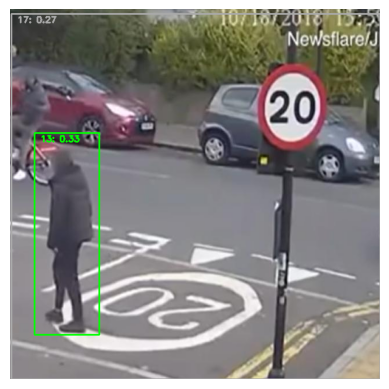

In [77]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

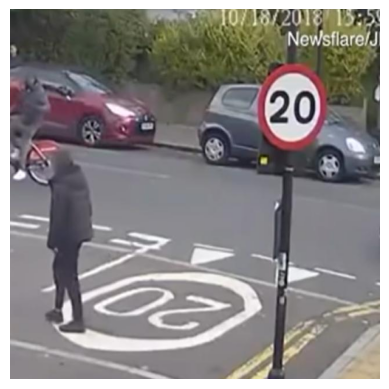

In [78]:
image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [79]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/541_png.rf.ec9614119dfe10f5fb1cda98f657b47e.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 (no detections), 8.9ms
Speed: 4.2ms preprocess, 8.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 1 yellow_light, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 1 yellow_light, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 1 yellow_light, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 1 yellow_light, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 1 yellow_light, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 1 yellow_light, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 1 yellow_light, 7.5ms

Generating adversarial examples...


0: 640x640 1 door, 1 yellow_light, 7.7ms
Speed: 0.0ms preprocess, 7.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 1 yellow_light, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 1 yellow_light, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 1 yellow_light, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 1 yellow_light, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 1 yellow_light, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 1 yellow_light, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 1 yellow_light,

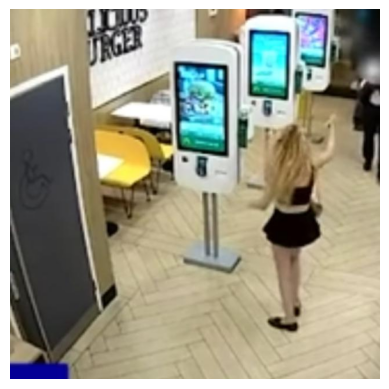

0.45


IndexError: list index out of range

In [80]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [81]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/552_png.rf.db52aefafea5e76c45f6d0d6eeb6760b.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 person, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 10.6ms
Speed: 0.1ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 64

Generating adversarial examples...
tensor(1.0030, device='cuda:0', grad_fn=<SubBackward0>)



WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 6

0.36


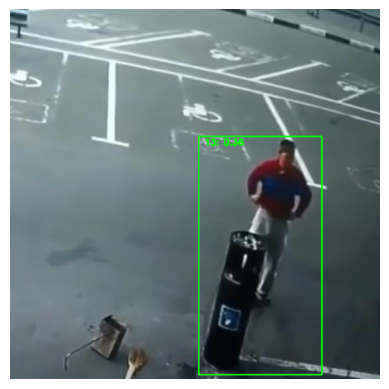

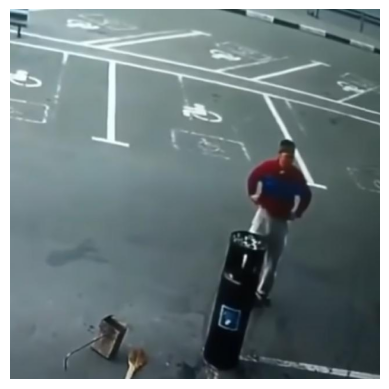

In [82]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [83]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/553_png.rf.53156c7f677314703d70b307e360efb6.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 2 persons, 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 64

Generating adversarial examples...
tensor(0.6436, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 1 person, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x6

tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 1 person, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0:

tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)



0: 640x640 1 person, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x

tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 1 person, 11.3ms
Speed: 0.0ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 0.1ms preprocess, 10.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 6

tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 1 person, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0:

tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)



0: 640x640 1 person, 8.6ms
Speed: 0.1ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x

tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 1 person, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 0.1ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x6

tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 1 person, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6787, device='cuda:0', grad_fn=<SubBackward0>)


0.52
0.39


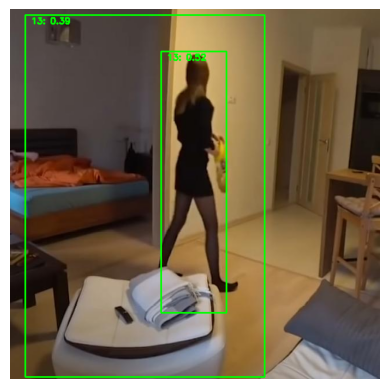

0.31


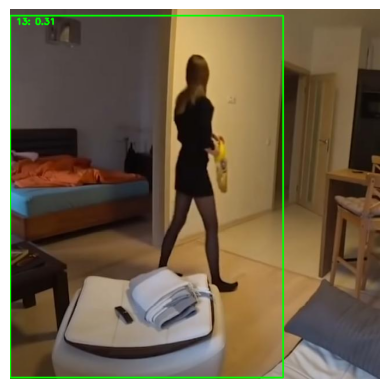

In [84]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [85]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/556_png.rf.04e60f97d172739af5012df81fcf73ab.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 rat, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.5ms

Generating adversarial examples...



0: 640x640 1 door, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 6.4ms
Speed: 0.0ms preprocess, 6.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.6ms
Speed: 0.1ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.3ms
Speed: 0.0ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.3ms
Speed: 0.0ms preprocess, 7.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.0m

0.33


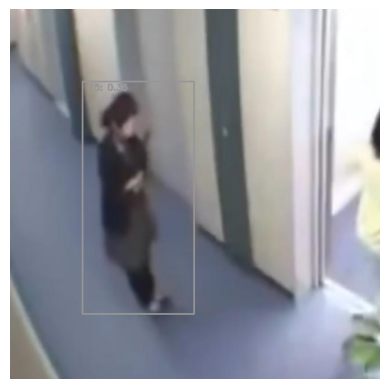

0.85


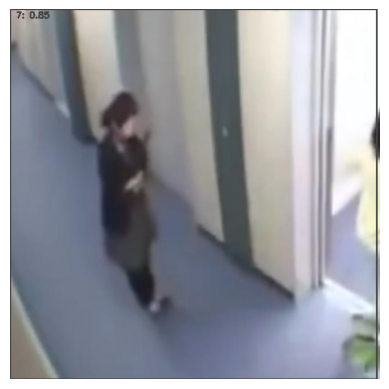

In [87]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [88]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/554_png.rf.537775b63b27818ceb81d8a71aa48abf.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 scooter, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 7.6ms
Speed: 0.1ms preprocess, 7.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating adversarial examples...


0: 640x640 1 scooter, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 6.6ms
Speed: 0.0ms preprocess, 6.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 6.7ms
Speed: 0.0ms preprocess, 6.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



0.33


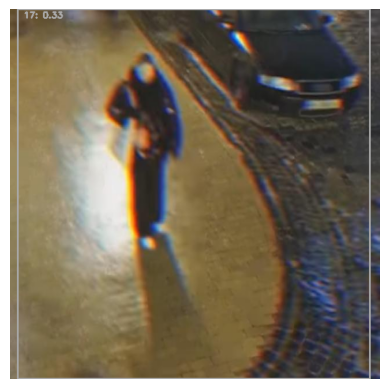

0.40


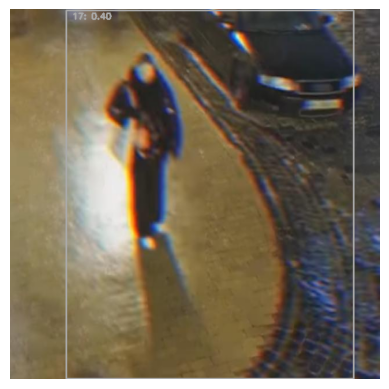

In [89]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [90]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/557_png.rf.8f5abb75a4102fc16dbaf19279e33389.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 elevator, 2 persons, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1,

Generating adversarial examples...
tensor(0.7801, device='cuda:0', grad_fn=<SubBackward0>)


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 8.1ms
Speed: 0.1ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 64

0.75
0.68
0.65


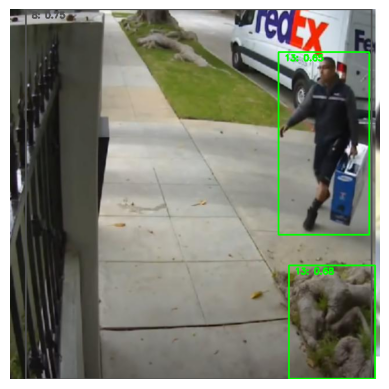

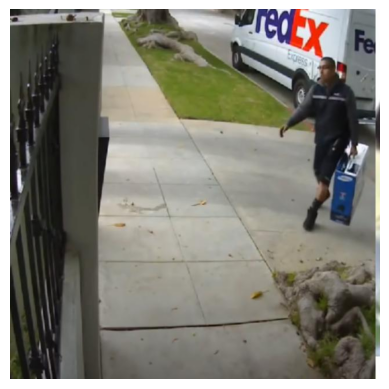

In [91]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [92]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/555_png.rf.446202f35c08bcb3670180cf46677a2a.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 person, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.4ms postpro

Generating adversarial examples...



0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.4ms
Speed: 0.0ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.1ms
Speed: 0.0ms preprocess, 6.1ms inference, 1.2ms 

0.41


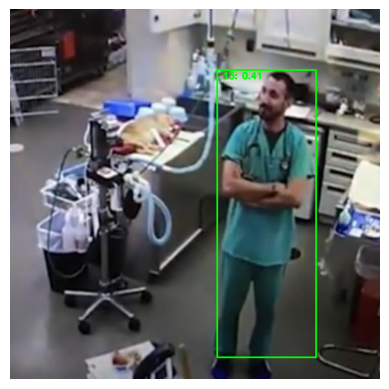

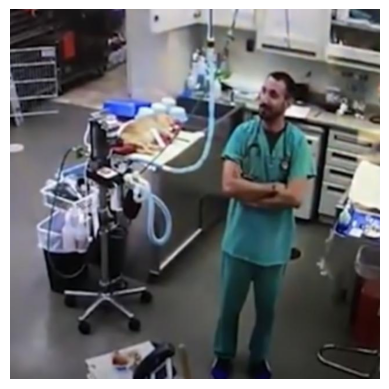

In [93]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [94]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/551_png.rf.a6f93649aaef547a01818b1a84c4daea.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 (no detections), 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.3ms 

Generating adversarial examples...


0: 640x640 (no detections), 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.8ms
Speed: 0.0ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.7ms
Speed: 0.0ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.3ms
Speed: 0.0ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.8ms
Speed: 0.0ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.7ms
Speed: 0.0ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.9ms
Speed: 0.0ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.8ms
Speed: 0.0ms preprocess, 6.8ms inference, 1.2ms p

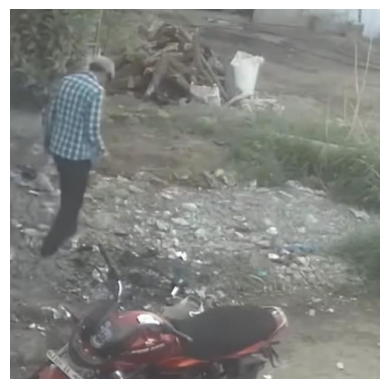

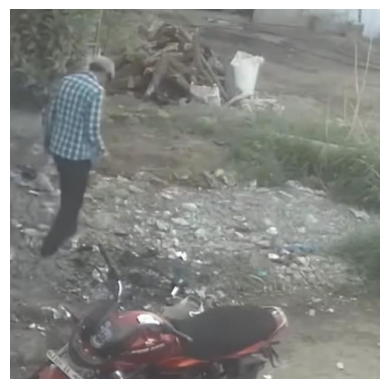

In [95]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [96]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/545_png.rf.49ce1de985fff5c22ca5f340decdffdb.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 car, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.9ms
Speed: 0.0ms preprocess, 7.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms

Generating adversarial examples...


0: 640x640 2 cars, 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.6ms
Speed: 0.0ms preprocess, 6.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.0ms

0.51


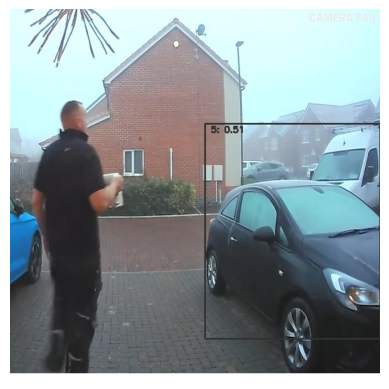

0.45
0.33


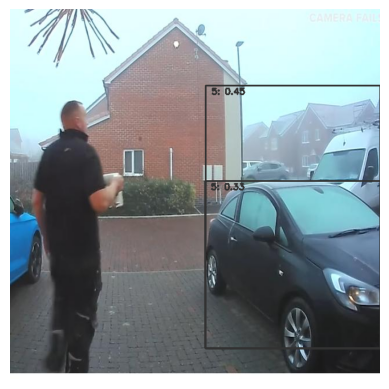

In [97]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [98]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/51_png.rf.127d6881ff6b79a0eccaa4998ac8f34b.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 person, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

Generating adversarial examples...
tensor(1.2075, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 8.5ms
Speed: 0.1ms preprocess, 8.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 2

0.76


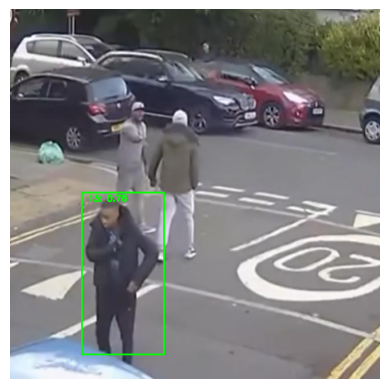

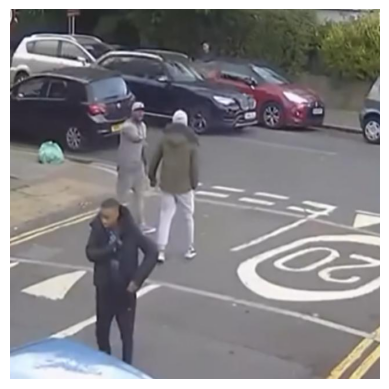

In [99]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [100]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/53_png.rf.b6aaa97737f85d6fa41b00637ab72fd9.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 person, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

Generating adversarial examples...
tensor(0.7053, device='cuda:0', grad_fn=<SubBackward0>)


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 8.6ms
Speed: 0.1ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 64

0.26


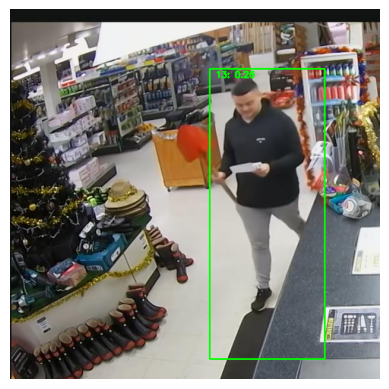

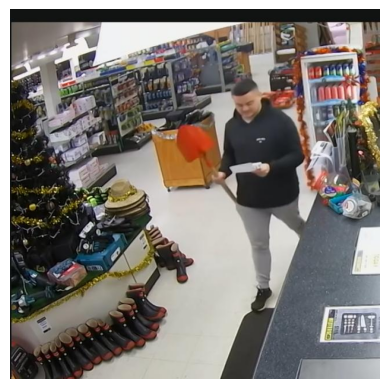

In [101]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()